In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as an
import scipy
import sklearn
import gget

In [2]:
sc.settings.verbosity = 3  

In [3]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/bj_10x_sc/scanpy/raw.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata.var_names = adata.var['gene_name'].values
sc.logging.print_memory_usage()

adata

Memory usage: current 1.90 GB, difference +1.90 GB


AnnData object with n_obs × n_vars = 10283 × 19393
    obs: 'n_genes'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand'

# QC Vars and Plots

In [4]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

sc.pp.scrublet(
    adata
)

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, log1p=True
)


# Calculate the percentage of cells expressing each gene
percent_expressing = np.sum(adata.X > 0, axis=0) / adata.shape[0] * 100

# Add the results to .var
adata.var['percent_expressing'] = percent_expressing

adata

Running Scrublet
filtered out 5087 genes that are detected in less than 3 cells
filtered out 723 cells that have less than 3 genes expressed
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:01)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 7.4%
    Scrublet finished (0:01:49)


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_qc.py:431: RuntimeWarning: invalid value encountered in divide
  return values / sums[:, None]


AnnData object with n_obs × n_vars = 10283 × 19393
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'percent_expressing'
    uns: 'scrublet'

# Cell Summary

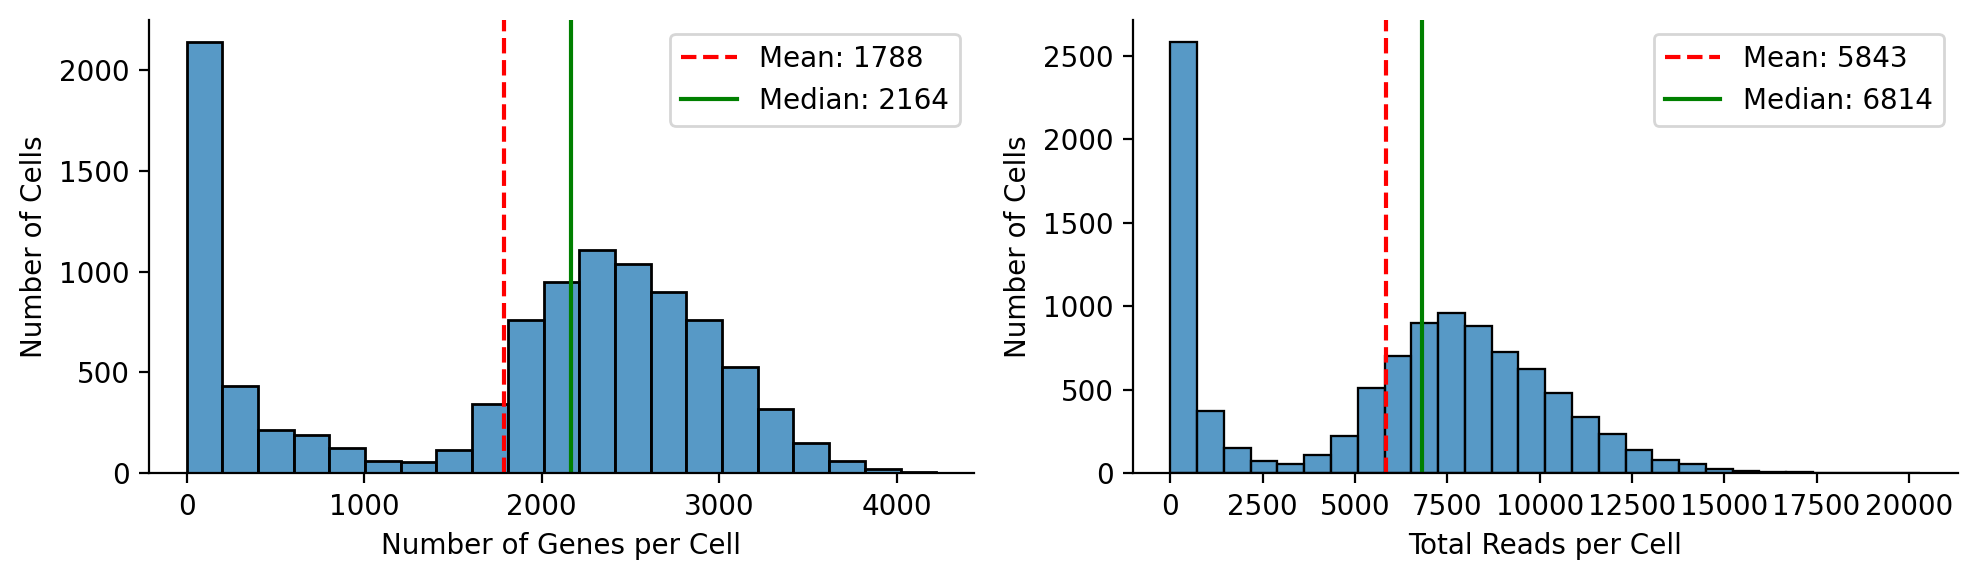

In [5]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 3

fig, axs = plt.subplots(1, 2)

# Plot for 'n_genes_by_counts'
sns.histplot(adata.obs, x='n_genes_by_counts', ax=axs[0]) 
mean_n_genes = adata.obs['n_genes_by_counts'].mean()
median_n_genes = adata.obs['n_genes_by_counts'].median()
axs[0].axvline(mean_n_genes, color='r', linestyle='--', label=f'Mean: {mean_n_genes:.0f}')
axs[0].axvline(median_n_genes, color='g', linestyle='-', label=f'Median: {median_n_genes:.0f}')
axs[0].legend()
axs[0].set_xlabel('Number of Genes per Cell')  # Update x-axis label
axs[0].set_ylabel('Number of Cells')  # Update x-axis label
axs[0].set_title('')  # Remove title

# Plot for 'total_counts'
sns.histplot(adata.obs, x='total_counts', ax=axs[1]) 
mean_total_counts = adata.obs['total_counts'].mean()
median_total_counts = adata.obs['total_counts'].median()
axs[1].axvline(mean_total_counts, color='r', linestyle='--', label=f'Mean: {mean_total_counts:.0f}')
axs[1].axvline(median_total_counts, color='g', linestyle='-', label=f'Median: {median_total_counts:.0f}')
axs[1].legend()
axs[1].set_xlabel('Total Reads per Cell')  
axs[1].set_ylabel('Number of Cells')  # Update x-axis label
axs[1].set_title('') 

sns.despine()
plt.tight_layout() 
plt.show()

Text(0.5, 73.44444444444441, 'Reads per Cell (log)')

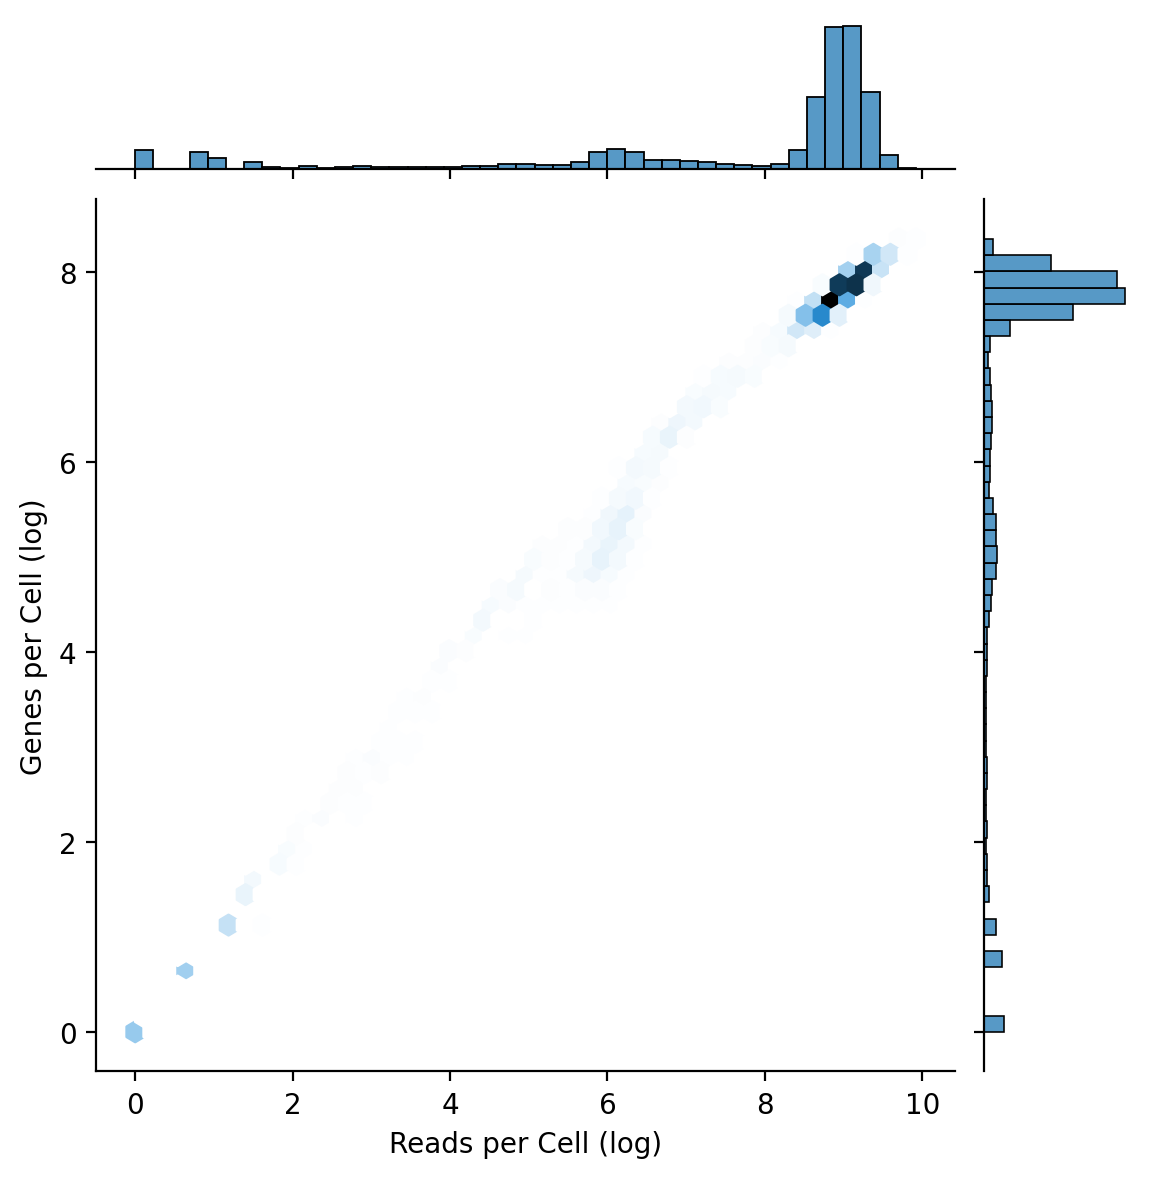

In [6]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sns.jointplot(
    data=adata.obs,
    x="log1p_total_counts",
    y="log1p_n_genes_by_counts",
    kind="hex",
)

plt.ylabel("Genes per Cell (log)")
plt.xlabel("Reads per Cell (log)")

# Gene Level Summary

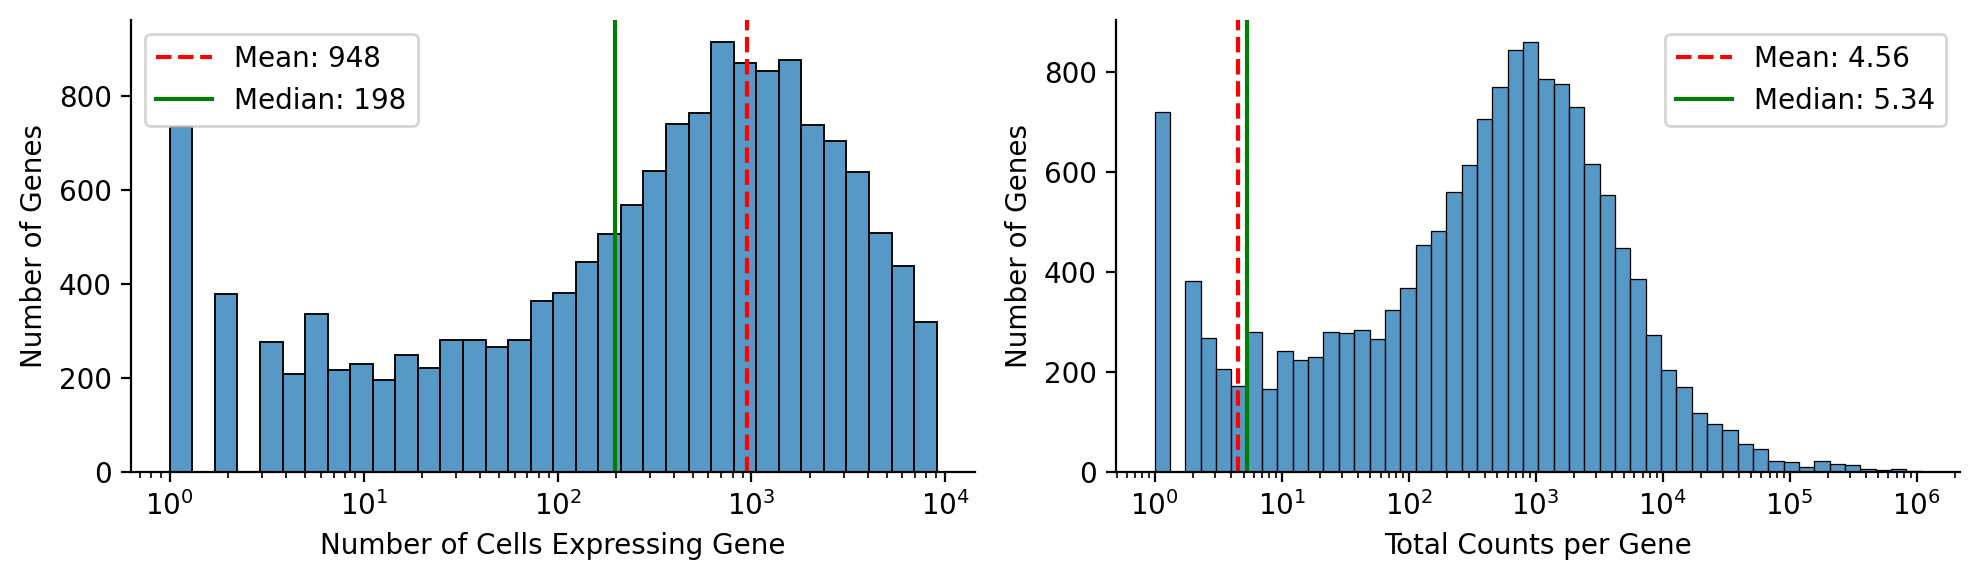

In [7]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 3

fig, axs = plt.subplots(1, 2)

# Plot for 'n_cells_by_counts'
sns.histplot(adata.var, x='n_cells_by_counts', ax=axs[0], log_scale=True) 
mean_n_cells = adata.var['n_cells_by_counts'].mean()
median_n_cells = adata.var['n_cells_by_counts'].median()
axs[0].axvline(mean_n_cells, color='r', linestyle='--', label=f'Mean: {mean_n_cells:.0f}')
axs[0].axvline(median_n_cells, color='g', linestyle='-', label=f'Median: {median_n_cells:.0f}')
axs[0].legend()
axs[0].set_xlabel('Number of Cells Expressing Gene')  
axs[0].set_ylabel('Number of Genes') 
axs[0].set_title('')

# Plot for 'total_counts'
sns.histplot(adata.var, x='total_counts', ax=axs[1], log_scale=True)
mean_total_counts = adata.var['log1p_total_counts'].mean()
median_total_counts = adata.var['log1p_total_counts'].median()
axs[1].axvline(mean_total_counts, color='r', linestyle='--', label=f'Mean: {mean_total_counts:.2f}')
axs[1].axvline(median_total_counts, color='g', linestyle='-', label=f'Median: {median_total_counts:.2f}')
axs[1].legend()
axs[1].set_xlabel('Total Counts per Gene')  
axs[1].set_ylabel('Number of Genes') 
axs[1].set_title('') 

sns.despine()
plt.tight_layout() 
plt.show()

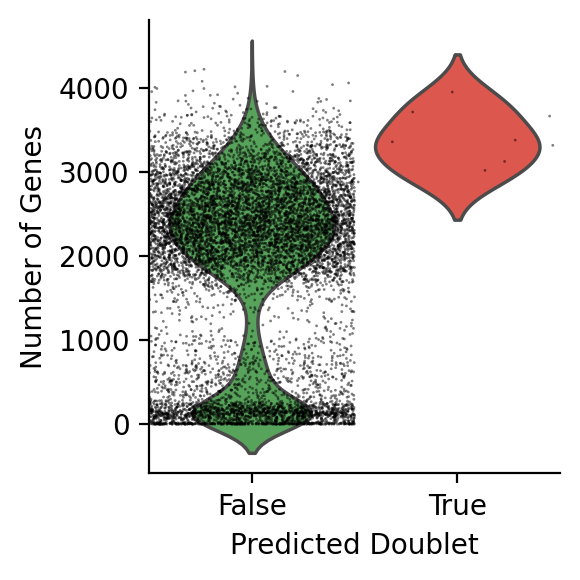

In [8]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

# Create the violin plot with jittered points
sns.violinplot(
    data=adata.obs,
    x='predicted_doublet',
    y='n_genes_by_counts',
    hue='predicted_doublet',
    palette=['#4CAF50', '#F44336'],
    inner=None  # Remove inner points from violin plot
)

# Add jittered points
sns.stripplot(
    data=adata.obs,
    x='predicted_doublet',
    y='n_genes_by_counts',
    c='k',
    s=1,
    jitter=0.5,  
    alpha=0.5,
    dodge=False,  
    edgecolor='none',  
)

sns.despine()

# Clean up axis labels
plt.xlabel('Predicted Doublet')
plt.ylabel('Number of Genes')

# Remove legend (since hue colors are self-explanatory)
plt.legend([],[], frameon=False) 

plt.tight_layout()
plt.show()

# Highly Expressed Genes 

In [29]:
adata.var

,gene_name,Chromosome,Start,End,Strand,mt,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,percent_expressing
ATAD3B,ATAD3B,1,1471764,1497848,+,False,False,778,0.082369,0.079152,92.434115,847,6.742881,7.565885
PRDM16,PRDM16,1,3069167,3438621,+,False,False,0,0.000000,0.000000,100.000000,0,0.000000,0.000000
SKI,SKI,1,2228318,2310213,+,False,False,2471,0.303608,0.265136,75.970048,3122,8.046549,24.029952
PEX14,PEX14,1,10472287,10630758,+,False,False,288,0.029563,0.029135,97.199261,304,5.720312,2.800739
PLCH2,PLCH2,1,2425979,2505532,+,False,False,362,0.036565,0.035913,96.479627,376,5.932245,3.520373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAZ3,DAZ3,Y,24763068,24813492,-,False,False,0,0.000000,0.000000,100.000000,0,0.000000,0.000000
DAZ1,DAZ1,Y,23129354,23199010,-,False,False,7,0.000681,0.000681,99.931926,7,2.079442,0.068074
AMELY,AMELY,Y,6865917,6911752,-,False,False,1,0.000097,0.000097,99.990275,1,0.693147,0.009725
RBMY1E,RBMY1E,Y,21903617,21918042,-,False,False,125,0.012350,0.012275,98.784401,127,4.852030,1.215599


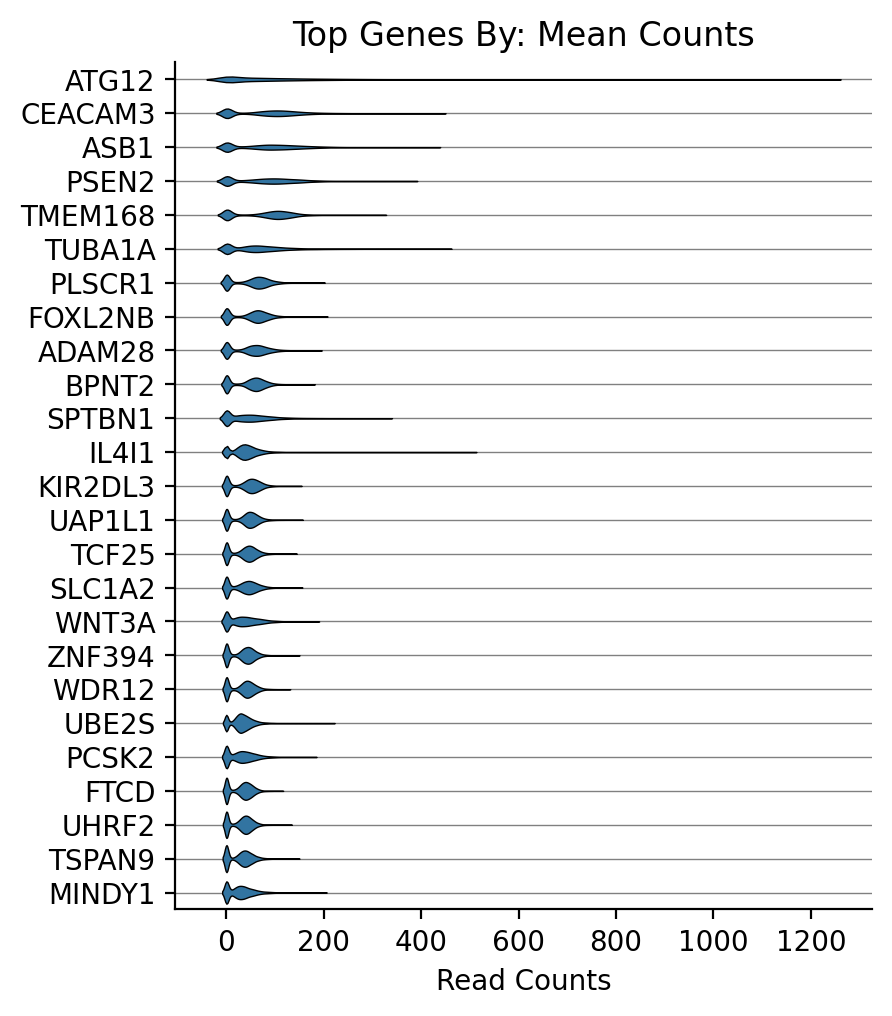

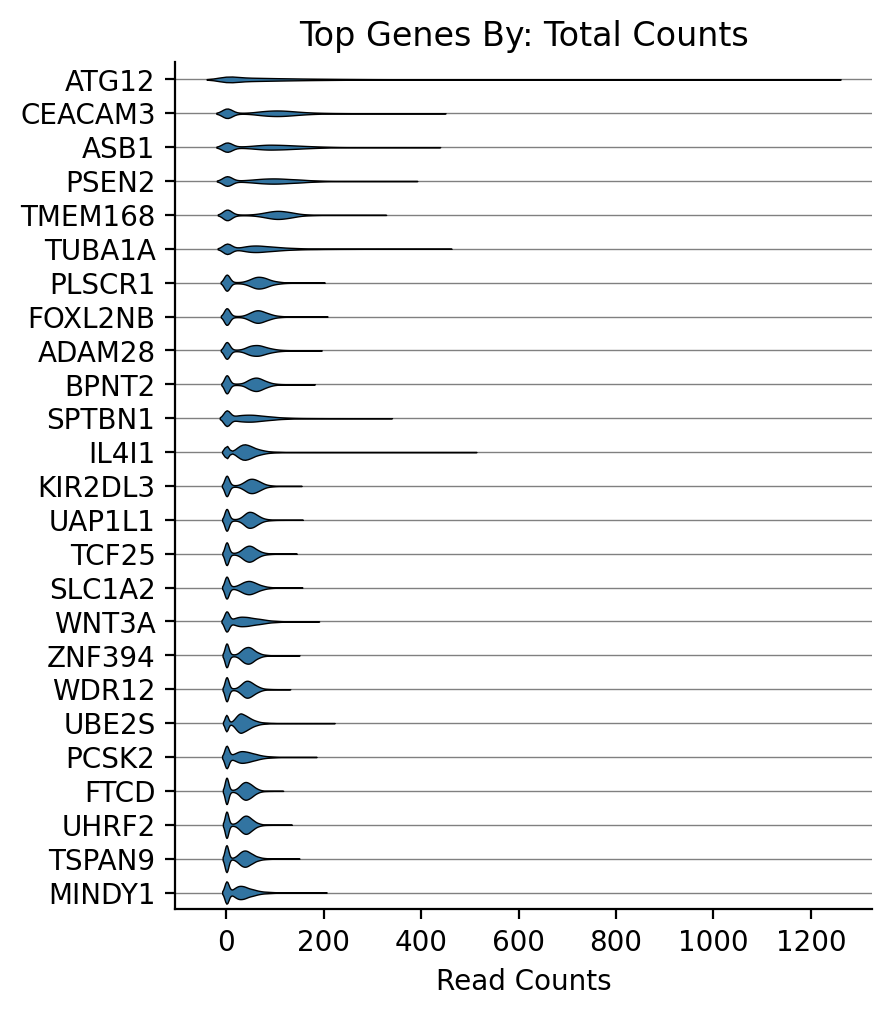

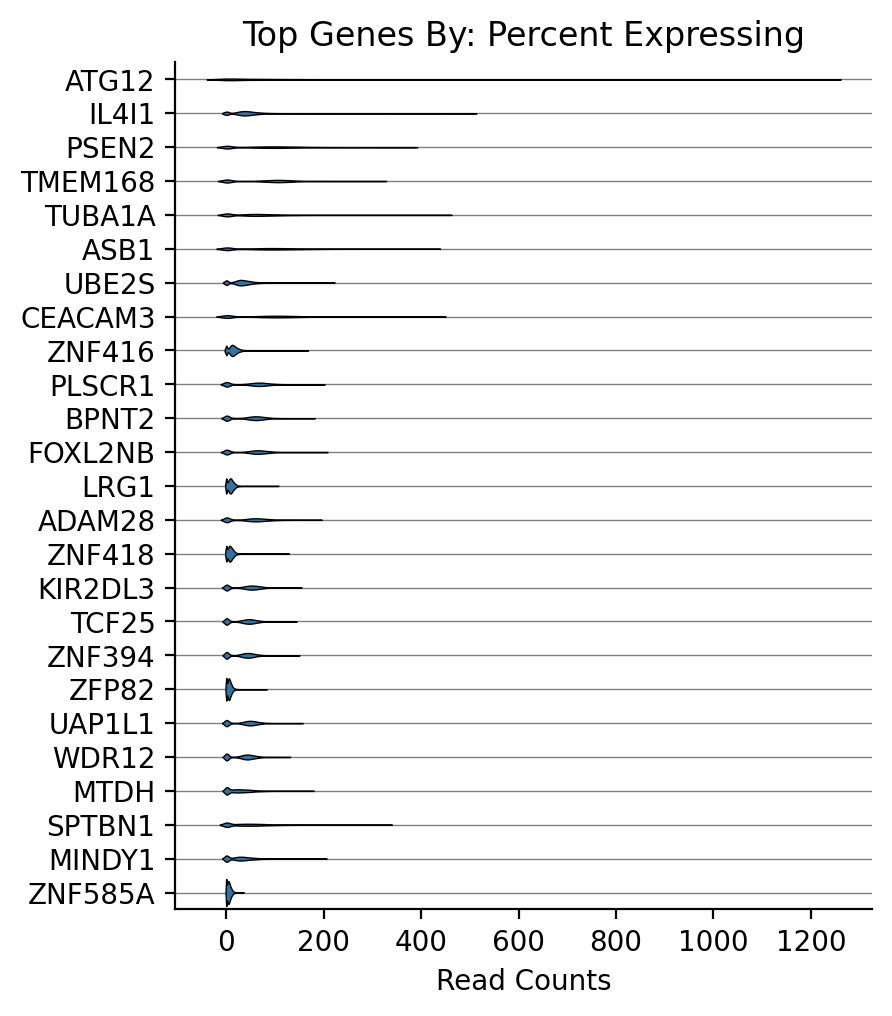

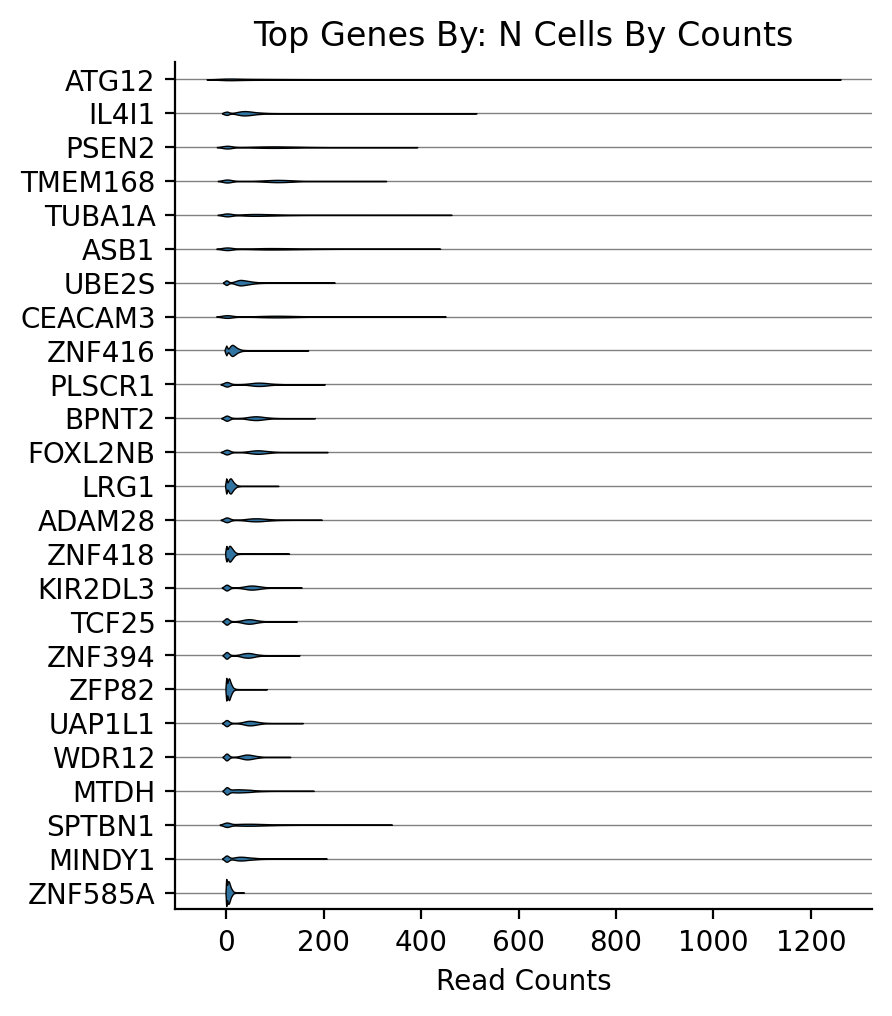

In [58]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4.5, 5.5

def get_top_by(adata, column, n_genes=25):
    var = adata.var.copy()
    var = var.sort_values(by=column, ascending=False)
    var = var.head(n_genes)
    return var[column]
    
    
columns = [
    'mean_counts',
    'total_counts',
    'percent_expressing',
    'n_cells_by_counts',
    
]
    
for column in columns:    
    result = get_top_by(adata, column)
    
    X = adata[:, result.index].to_df().reset_index(names='cell_id').copy()
    X = pd.melt(X, id_vars='cell_id')
    
    sns.violinplot(
        data=X,
        y='variable',
        x='value',
        inner=None,
        linewidth=0.5,
        linecolor='k',
    )

    # Get the ytick locations
    yticks = plt.gca().get_yticks()

    # Draw horizontal lines at each ytick
    for y in yticks:
        plt.axhline(
            y=y, 
            color='gray', 
            linestyle='-', 
            linewidth=0.5, 
            zorder=-1,
        ) 
    
    plt.ylabel("")
    plt.xlabel("Read Counts")
    plt.title(f"Top Genes By: {column.title().replace("_", ' ')}")
    sns.despine()
    plt.show()

# Fibroblast genes

In [73]:
def build_dataframe(data_file):
    """
    Builds a pandas DataFrame from a data file with the specified format.

    Args:
        data_file (str): Path to the data file.

    Returns:
        pandas.DataFrame: A DataFrame containing the parsed data.
    """

    data = []
    with open(data_file, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            parts = [x for x in parts if not x == '']
            path_name, *gene_list = parts 

            for gene in gene_list:
                data.append({'path_name': path_name, 'gene_name': gene})

    df = pd.DataFrame(data)
    return df


fpath = "../resources/PanglaoDB_Augmented_2021.txt"
df = build_dataframe(fpath)
df = df[df['path_name'] == 'Fibroblasts']
print(f"{df.shape=}")
df.head()

df.shape=(232, 2)


,path_name,gene_name
7174,Fibroblasts,ENTPD2
7175,Fibroblasts,LUM
7176,Fibroblasts,IL1R1
7177,Fibroblasts,RUNX1
7178,Fibroblasts,CELA1


In [76]:
fib_genes = list(df['gene_name'].unique())
fib_genes = [x for x in fib_genes if x in adata.var_names]
print(len(fib_genes))
fib_genes[:10]

231


['ENTPD2',
 'LUM',
 'IL1R1',
 'RUNX1',
 'CELA1',
 'DKK1',
 'DKK3',
 'COL1A2',
 'COL1A1',
 'CCDC80']

['SNAP29' 'CFAP47' 'CYLC1' 'NUDT5' 'KLHL38' 'SMIM34' 'CGB3' 'FGA'
 'CEACAM21' 'CMTM4']


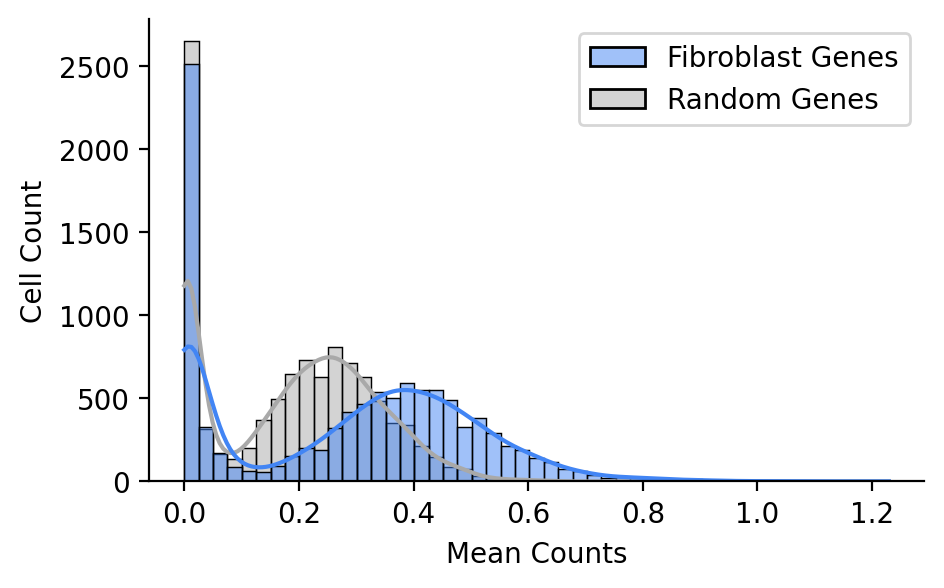

In [112]:
def average_expression_comparison(adata, gene_list):
    """
    Calculates the average expression of a given gene list and a randomly sampled gene list of the same length.

    Args:
        adata (AnnData): An AnnData object containing gene expression data.
        gene_list (list): A list of gene names to analyze.

    Returns:
        pandas.DataFrame: A DataFrame with two columns: 'Average Expression of Given Genes' and 'Average Expression of Random Genes'.
    """

    # Get average expression of the given gene list
    avg_expr_given = np.mean(adata[:, gene_list].X, axis=1)

    # Randomly sample genes (same length as the input list)
    random_genes = np.random.choice(
        adata.var_names, 
        size=len(gene_list), 
        replace=False,
    )

    # Get average expression of the randomly sampled genes
    avg_expr_random = np.mean(adata[:, random_genes].X, axis=1)

    # Create a DataFrame
    df = pd.DataFrame({
        'cell_id' : adata.obs_names,
        'query': avg_expr_given,
        'control': avg_expr_random
    })

    return df, random_genes


pdf, control_genes = average_expression_comparison(adata, fib_genes)
print(control_genes[:10])
pdf.columns = ['cell_id', 'Fibroblast Genes', 'Random Genes']

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3

sns.histplot(
    data=pd.melt(pdf, id_vars='cell_id'),
    x='value',
    hue='variable',
    kde=True,
    palette=['#4285F4', '#A9A9A9'],
)
sns.move_legend(
    plt.gca(),
    title="",
    loc='best',
)

plt.xlabel('Mean Counts')
plt.ylabel('Cell Count')
sns.despine()

In [114]:
def permutation_test(adata, gene_list, num_permutations=1000):
    """
    Performs a permutation test to assess the significance of the difference in average expression
    between a given gene list and randomly sampled gene lists.

    Args:
        adata (AnnData): An AnnData object containing gene expression data.
        gene_list (list): A list of gene names to analyze.
        num_permutations (int, optional): The number of permutations to perform. Defaults to 1000.

    Returns:
        tuple: A tuple containing:
            - float: The observed mean difference in expression.
            - float: The p-value representing the significance of the observed difference.
    """

    # Calculate the observed difference in average expression
    pdf, _ = average_expression_comparison(adata, gene_list)
    observed_diff = np.mean(pdf['query']) - np.mean(pdf['control'])

    # Perform permutations
    num_exceed_observed = 0
    for _ in range(num_permutations):
        permuted_pdf, _ = average_expression_comparison(adata, gene_list)
        permuted_diff = np.mean(permuted_pdf['query']) - np.mean(permuted_pdf['control'])
        if permuted_diff >= observed_diff:
            num_exceed_observed += 1

    # Calculate the p-value
    p_value = num_exceed_observed / num_permutations

    # Print the results
    print(f"Observed mean difference: {observed_diff:.4f}")
    print(f"P-value: {p_value:.4f}")

    return observed_diff, p_value

mean_diff, p_value = permutation_test(adata, fib_genes)
print(f"{mean_diff=}")
print(f"{p_value=}")


Observed mean difference: -0.0250
P-value: 0.6320
mean_diff=-0.025030174208429623
p_value=0.632


In [10]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
adata.var.columns

In [ ]:
break

In [ ]:
adata.var.head()

In [ ]:
break

# Filtering, Normalization and Variance Stabilization

In [ ]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

# filtration
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [ ]:
break

# Clustering and Low-Dimensional Representation

In [ ]:
sc.pp.highly_variable_genes(adata)

sc.pp.pca(adata)
              
sc.pp.neighbors(
    adata, 
)
sc.tl.umap(adata)
sc.tl.leiden(
    adata, 
    resolution=0.3, 
)

sc.pl.umap(adata, 
          color=['leiden'])

In [ ]:
adata.obs.columns

In [ ]:
sc.pl.umap(adata, 
          color=['n_genes', 
                 'n_genes_by_counts', 
                 'pct_counts_in_top_100_genes', 
                 'pct_counts_mt'])

In [ ]:
sc.pl.umap(adata, 
          color=['doublet_score', 
                 'predicted_doublet',])